# Subject-driven Image Generation

#### 학습 목표

> 본 실습에서는 Stable Diffusion을 응용하여 Subject-driven Image Generation을 수행하는 연구들에 대해서 알아보고자 한다.

**목차**
> Subject-driven Image Generation
>
> 1. Textual Inversion (ICLR'23 notable-top-25%)
> 2. DreamBooth (CVPR'23 Hornorable Mention (Student))

> 다음은 본 실습에 필요한 library와 시각화 함수이다. 아래 실습 전에 실행하도록 하자.

In [ ]:
!pip install diffusers

In [ ]:
import torch
import torchvision.transforms as T
from IPython.display import display
from PIL import Image
from torchvision.utils import make_grid

from diffusers.utils import load_image


def display_images_with_grid(images, size=(256, 256), nrow=4):
    tf = T.Compose([T.Resize(size), T.ToTensor()])
    grid = make_grid(torch.stack([tf(img) for img in images]), nrow=nrow)
    return T.ToPILImage()(grid)

# Subject-driven Image Generation


> Subject-driven image generation은 특정한 subject (사람, 동물, 또는 임의의 물체)에 대한 몇 장의 사진을 통해서 해당 subject의 특징을 알아내고, 이를 이용하여 해당 subject에 대해 다양한 상황을 연출할 수 있도록 이미지를 생성하는 방법론이다.
>
> 이는 text-to-image generation이 diffusion models의 등장을 통해서 다양하고 복잡한 이미지를 생성할 수 있게 되면서 등장한 연구 주제로 최근 많은 연구가 진행되고 있다.
>
> 먼저 subject-driven image generation이라는 주제를 처음으로 제안한 Textual Inversion에 대해서 알아보자.

## 1. Textual Inversion (ICLR'23 notable-top-25%)

> - Gal et al., "An Image is Worth One Word: Personalizing Text-to-Image Generation using Textual Inversion" ICLR. 2023.
> - [[Paper](https://arxiv.org/abs/2208.01618)] [[Code](https://github.com/rinongal/textual_inversion)] [[Project page](https://textual-inversion.github.io)]


> Textual inversion은 논문 제목 (An Image is Worth One Word)을 보면 알 수 있듯이, subject에 대해서 하나의 단어로 나타내고자 하는 방법론이다.
>
> 예를 들어, 아래 그림과 같이 독특한 모양의 조각상이 있을 때, 이를 learnable word embedding인 S\*로 압축한 뒤, 추후 S\*를 하나의 단어로 보아 "An oil painting of S\*", "App icon of S\*"처럼 문장의 형태로 만들어 이미지를 생성하는 것이다.
>
> <img src="https://textual-inversion.github.io/static/images/editing/teaser.JPG" width=800>

> S\*를 학습하기 위한 방법론은 다음과 같다.
>
> 1. 학습하고자 하는 subject에 대한 사진을 모은다.
> 2. 아래 그림과 같이 새로운 learnable word embedding인 S\*를 초기화한다.
> 3. Text encoder, denoising UNet 등 text-to-image를 위한 다른 모든 parameter는 freeze한다.
> 4. Diffusion model을 학습할 때 사용하였던 reconstruction loss를 똑같이 이용하여 learnable word embedding인 S\*를 optimize한다.
>
> <img src="https://github.com/pmh9960/images/blob/main/textual_inversion_method.png?raw=true" width=800>

> 위 학습 방법에서 알 수 있듯이, textual inversion은 기존 diffusion models을 학습하던 reconstruction loss를 그대로 사용하되, 이번에는 pre-trained diffusion model은 freeze한 채로 한 단어 S\*를 학습한다.
>
> 즉, 잘 학습된 diffusion model을 이용하여 학습에 사용된 subject를 생성할 수 있는 단어를 찾는 것이고, 이 방법이 현재 그림에 맞는 text를 역으로 찾는 것이라고 하여 textual inversion이라고 불린다.

> 이제 아래 실습을 통해서 textual inversion으로 학습된 "cat-toy"를 여러 상황으로 재구성하여 생성해보자.
>
> Textual inversion으로 압축된 word embedding들은 보통 아래 링크에서 서로 공유하니 더 다양한 subject에 대한 word embedding은 아래 링크를 참고하자.
> - [Huggingface SD Concepts Library](https://huggingface.co/sd-concepts-library)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

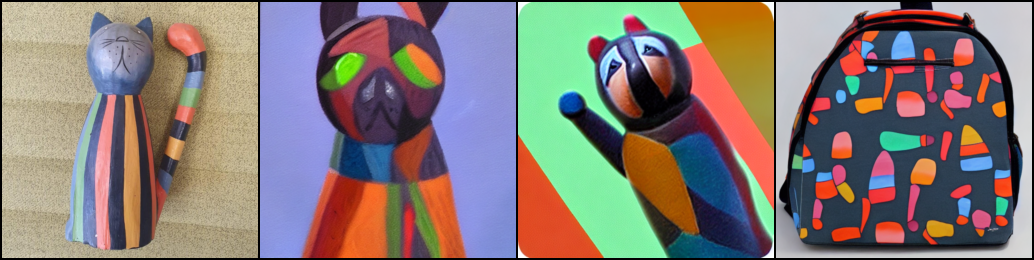

In [ ]:
import torch

from diffusers import StableDiffusionPipeline


pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16).to("cuda")
token_identifier = "cat-toy"
pipe.load_textual_inversion(f"sd-concepts-library/{token_identifier}")

orig_image = load_image('https://github.com/pmh9960/images/blob/main/cat-toy.jpg?raw=true')

prompts = [
    f"An oil painting of <{token_identifier}>",
    f"App icon of <{token_identifier}>",
    f"A <{token_identifier}> themed backpack",
]

images = pipe(
    prompts,
    num_inference_steps=50,
    generator=torch.manual_seed(1),
).images

display_images_with_grid([orig_image, *images], size=(256, 256), nrow=4)

> 가장 왼쪽에 있는 사진이 학습에 사용되었던 실제 "cat-toy"이다.
>
> 생성된 결과를 보면 알 수 있듯이, "cat-toy"의 느낌은 잘 살렸으나 원하는 만큼의 퀄리티를 얻어내지는 못하였다.
>
> 이는 learnable parameter가 단 하나의 word embedding으로 평소 우리가 학습시키는 network에 비교하면 아주 적기 때문이다.
> 그렇다면, 이 문제를 해결하여 더 높은 수준의 subject-driven image generation을 수행한 Dreambooth에 대해서 알아보자.

## 2. DreamBooth (CVPR'23 Honorable Mention (Student))

> - Ruiz et al., "DreamBooth: Fine Tuning Text-to-Image Diffusion Models for Subject-Driven Generation" CVPR. 2023.
> - [[Paper](https://arxiv.org/abs/2208.12242)] [[Dataset](https://github.com/google/dreambooth)] [[Project page](https://dreambooth.github.io)]


> Dreambooth는 textual inversion과 똑같이 subject-driven image generation을 수행하는 방법론이다.
>
> 이 때 textual inversion과 가장 큰 차이점은, textual inversion은 diffusion model은 모두 freeze한 채로 learnable word embedding을 학습하는 반면, Dreambooth는 diffusion model을 fine-tuning하여 일반적인 scene을 생성하던 text-to-image model을 특정 subject만 생성하도록 personalizing (개인화) 한다는 것이다.
>
> <img src="https://dreambooth.github.io/DreamBooth_files/teaser_static.jpg" width=800>
>
> - Dreambooth가 subject-driven image generation을 수행하는 예시
>
> <img src="https://dreambooth.github.io/DreamBooth_files/high_level.png" width=800>
>
> - Dreambooth의 high-level 구조

> 그렇다면 이제 Dreambooth는 어떤 방식으로 diffusion model을 학습하는지 알아보자.
>
> Dreambooth 역시도 textual inversion과 마찬가지로 subject에 대한 사진을 모은 뒤, 이를 이용하여 diffusion model이 학습할 때 사용하였던 reconstruction loss를 똑같이 이용한다.
> 차이점은 textual inversion과의 차이로는 word embedding과 더불어 diffusion model 전체를 추가로 학습시킨다는 것이다.
>
> 이 때, 적은 수(대략 3-5장)의 subject 사진으로 학습을 시키기 때문에, diffusion model이 fine-tuning을 하는 과정에서 overfitting이 쉽게 일어나게 된다.
> Diffusion model에서의 overfitting이란 사용자가 어떤 text를 입력으로 주는지에 관계 없이 학습 때 주었던 이미지만을 반복적으로 생성하게 된다는 것이다.
> 예를 들어 "[V] dog"로 입력을 주지 않아도 "[V] dog"를 생성하거나 학습 때 만약 앉아있는 "[V] dog"만을 입력으로 준다면 "[V] dog swimming on the beach"로 입력을 주어도 여전히 학습 때 사용하였던 이미지인 앉아있는 "[V] dog"만을 생성하는 문제이다.
>
> 이는 textual inversion에서는 일어나지 않았던 문제점으로 학습되는 parameter가 diffusion model 전체가 되면서 발생하게 된 문제이다.
>
> 이 문제를 해결하기 위해서 Dreambooth에서는 "Class-specific prior preservation loss"를 제안하였다.
>
> <img src="https://dreambooth.github.io/DreamBooth_files/system.png" width=800>
>
> - Dreambooth의 전체적인 학습 방법론

> Class-specific prior preservation loss는 학습에 사용된 subject가 먼저 어떤 class인지에 대한 정보를 사용한다.
> 위 예시에서는 강아지 중 하나를 학습하는 것이기 때문에 "A dog"라는 정보를 사용할 것이다.
>
> Class-specific prior preservation loss는 사전에 "A dog"라는 문자열을 이용하여 기존 diffusion model로 이미지를 생성해 둔 후, 이후 fine-tuning 할 때 "A [V] dog"를 활용하여 subject에 대한 이미지만을 학습하는 것이 아니라 기존 "A dog"에 대한 이미지를 추가로 함께 번갈아가며 학습하여 overfitting을 방지하는 방법론이다.
>
> Dreambooth에서 제안하는 이 class-specific prior preservation loss의 목적은 학습에 사용되는 subject 외 동일한 class들을 함께 학습하며 class에 대한 prior를 보존하여 여전히 다양한 강아지를 생성할 수 있도록 하고 이를 통해 이후 "A [V] dog swimming on the beach"와 같은 다양한 상황에 대해서 class prior를 적용하여 적절하게 생성할 수 있도록 하는 것이다.

> 이제 Dreambooth 역시 실습을 통해서 사전에 학습되었던 Dreambooth model을 이용하여 subject-driven image generation을 수행해보자.
>
> 본 실습에서는 "Mr. Potato Head"를 학습한 Dreambooth model을 이용하여 "Mr. Potato Head"에 대해 다양한 상황을 연출해볼 것이다.
> 더욱 다양한 subject에 대한 Dreambooth model은 아래 링크에서 서로 공유하니 참고하도록 하자.
>
> - [Huggingface SD Dreambooth Library](https://huggingface.co/sd-dreambooth-library?sort_models=likes#models)

In [ ]:
from diffusers import AutoPipelineForText2Image
import torch

pipeline = AutoPipelineForText2Image.from_pretrained("sd-dreambooth-library/mr-potato-head", torch_dtype=torch.float16, safety_checker=None).to("cuda")

  0%|          | 0/50 [00:00<?, ?it/s]

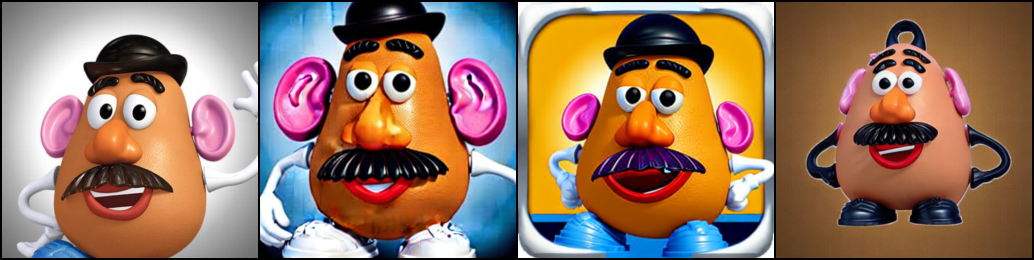

In [ ]:
orig_image = load_image('https://github.com/pmh9960/images/blob/main/mr_potato_head.jpeg?raw=true')
prompts = [
    f"An oil painting of sks mr potato head",
    f"App icon of sks mr potato head",
    f"A sks mr potato head themed backpack",
]
images = pipeline(prompts, generator=torch.manual_seed(1)).images
display_images_with_grid([orig_image, *images], size=(256, 256), nrow=4)

> Textural inversion과 비교하였을 때, Dreambooth가 더 기존 subject를 잘 유지하며 추가된 문자열에 맞게 이미지를 생성하는 것을 확인할 수 있다.
>
> 위 제공된 모델도 포함하여 최근에는 Dreambooth가 모든 diffusion model의 parameter를 fine-tuning하는 것이 아니라 LoRA 방법론과 결합하여 일부 parameter만을 학습하여 overfitting을 방지하고 있으니 더욱 자세한 내용은 아래 링크를 참고하도록 하자.
>
> - [Hugging face Dreambooth + LoRA 예시](https://huggingface.co/docs/peft/task_guides/dreambooth_lora)